# WT Aged Mice
## Xiaonan Wang
## 18May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [7]:
cr_dir = '/rds/project/rds-SDzz0CATGms/users/ti283/SLX18935/Patel_SLX18935/'

In [9]:
def ReadInFiles(cr_dir, folder_name, mouseID, Condition, Age, Tissue, Sex):
    adata = sc.read_10x_h5(cr_dir+'/'+folder_name+'/outs/filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    adata.obs['mouseID'] = mouseID
    adata.obs['Condition'] = Condition
    adata.obs['Age'] = Age
    adata.obs['Tissue'] = Tissue
    adata.obs['Sex'] = Sex
    return adata

In [10]:
E3 = ReadInFiles(cr_dir, 'SIGAE3', 'M00010779', 'WT', '68-week','BM','Female')
A7 = ReadInFiles(cr_dir, 'SIGAA7', 'KJAJ10.1e', 'WT', '16-week','BM','Female')
H3 = ReadInFiles(cr_dir, 'SIGAH3', 'M00010105', 'Fancd2 hetero', '88-week','BM','Male')

reading /rds/project/rds-SDzz0CATGms/users/ti283/SLX18935/Patel_SLX18935//SIGAE3/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /rds/project/rds-SDzz0CATGms/users/ti283/SLX18935/Patel_SLX18935//SIGAA7/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /rds/project/rds-SDzz0CATGms/users/ti283/SLX18935/Patel_SLX18935//SIGAH3/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
# Combine data sets
adata = E3.concatenate(A7, H3)

In [15]:
adata.obs['mouseID'] = adata.obs['mouseID'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
adata.obs['Age'] = adata.obs['Age'].astype('category')
adata.obs['Tissue'] = adata.obs['Tissue'].astype('category')
adata.obs['Sex'] = adata.obs['Sex'].astype('category')

print(adata.obs['mouseID'].cat.categories)
print(adata.obs['Condition'].cat.categories)
print(adata.obs['Age'].cat.categories)
print(adata.obs['Tissue'].cat.categories)
print(adata.obs['Sex'].cat.categories)

Index(['KJAJ10.1e', 'M00010105', 'M00010779'], dtype='object')
Index(['Fancd2 hetero', 'WT'], dtype='object')
Index(['16-week', '68-week', '88-week'], dtype='object')
Index(['BM'], dtype='object')
Index(['Female', 'Male'], dtype='object')


In [16]:
print(adata.obs['Age'].value_counts().sort_index())

16-week    7432
68-week    8409
88-week    9712
Name: Age, dtype: int64


# Doublet Detection

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 25.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Elapsed time: 12.9 seconds
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 25.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 8.7 seconds
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 24.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calcul

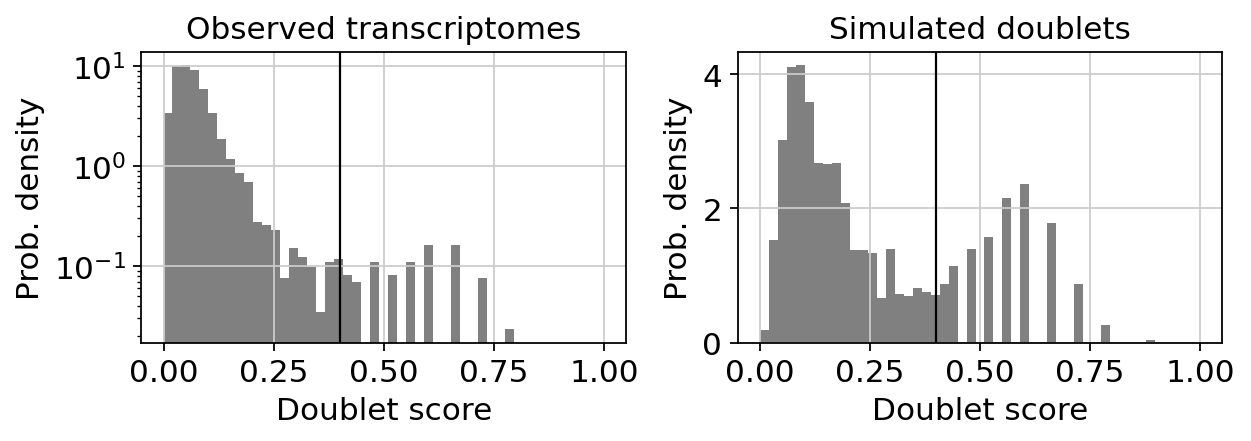

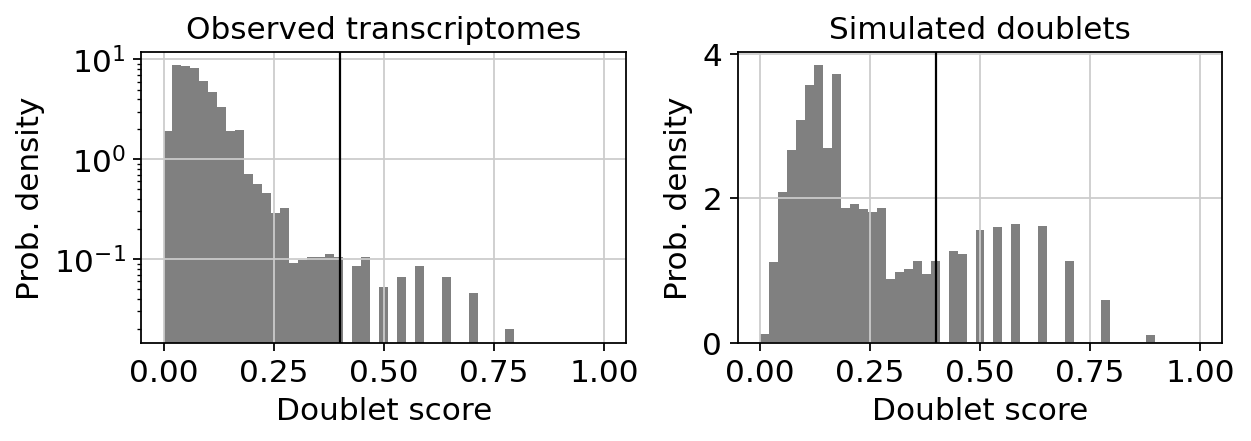

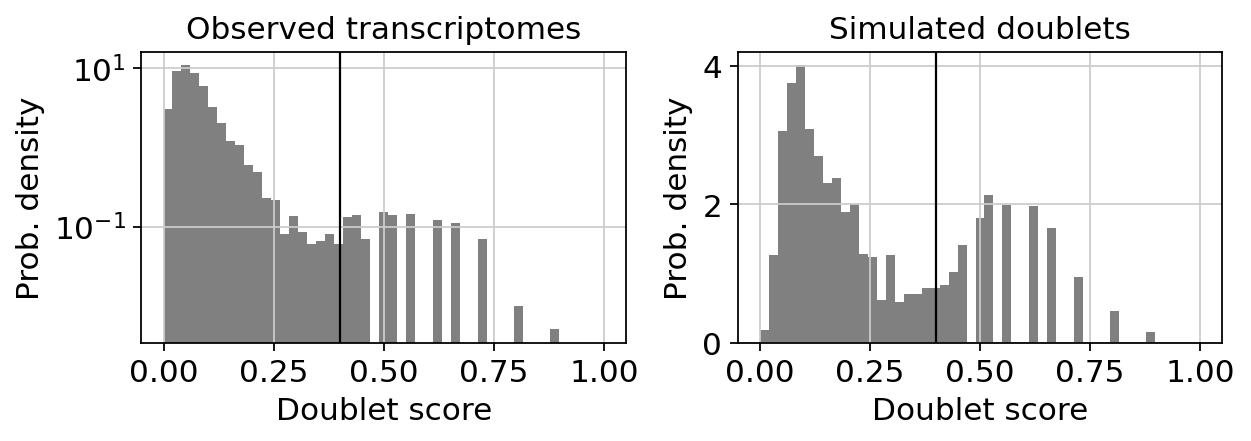

In [17]:
# Then calculate the doublet score to remove potential doublets
import scrublet as scr
db_scores = []
predicted_db = []
Cells = np.array([])
for i in np.unique(adata.obs['batch']):
    idx_sub = (adata.obs['batch']==i)
    Cells = np.append(Cells, adata[idx_sub,:].obs_names)
    scrub = scr.Scrublet(adata[idx_sub,:].X)
    scrub.scrub_doublets()
    scrub.call_doublets(threshold=0.4)
    doublet_scores = scrub.doublet_scores_obs_
    predicted_doublets = scrub.predicted_doublets_
    scrub.plot_histogram();
    db_scores.append(doublet_scores)
    predicted_db.append(predicted_doublets)

In [18]:
db_results = {'doublet_scores': np.concatenate(db_scores),
              'predicted_doublets': np.concatenate(predicted_db)
             }
db_results = pd.DataFrame.from_dict(db_results)
db_results.index = Cells

In [20]:
# save the doublet score in adata
adata = adata[Cells,:].copy()
adata.obs['doublet_score'] = db_results['doublet_scores'].values

In [21]:
print(adata.shape)
print('Total # of doublets: '+str(np.sum(db_results['predicted_doublets'])))

(25553, 27998)
Total # of doublets: 465


In [22]:
# then remove doublet cells
adata = adata[~db_results['predicted_doublets'].values,:].copy()

In [23]:
print(adata.shape)
print(adata.obs['Age'].value_counts().sort_index())

(25088, 27998)
16-week    7336
68-week    8258
88-week    9494
Name: Age, dtype: int64


# Quality Control

In [25]:
# look at mito contents
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

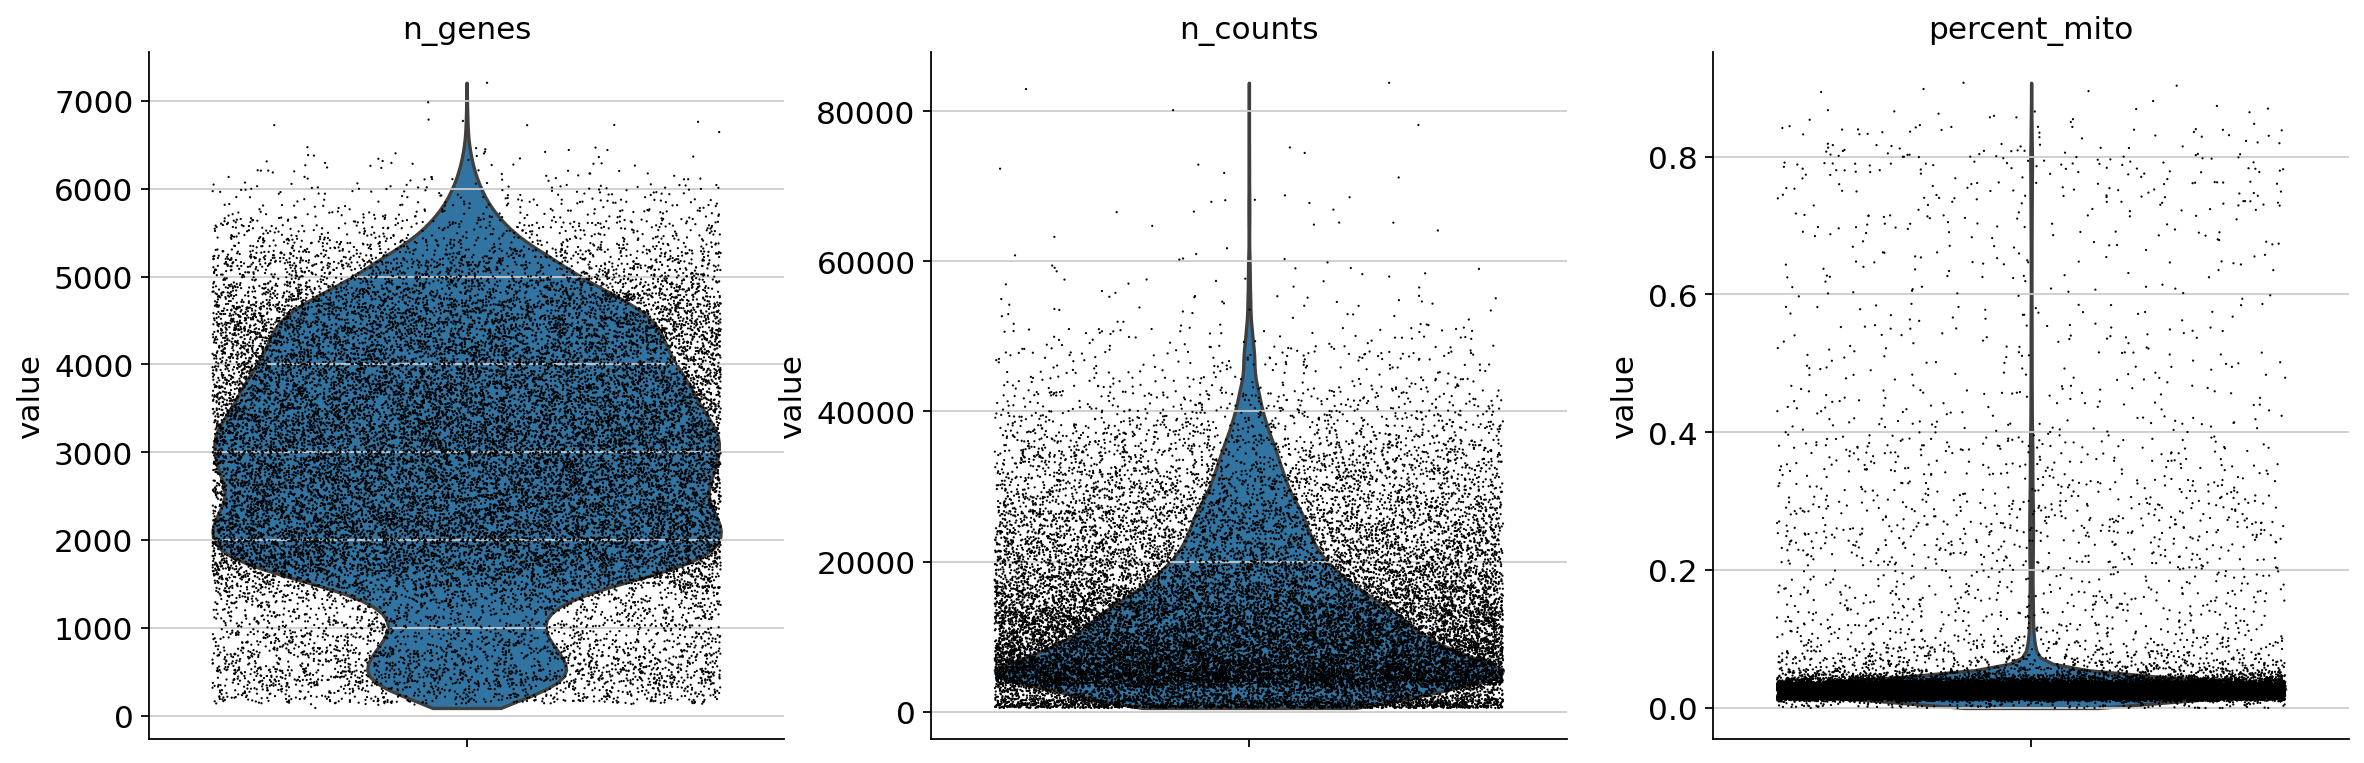

In [27]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

normalizing counts per cell
    finished (0:00:00)


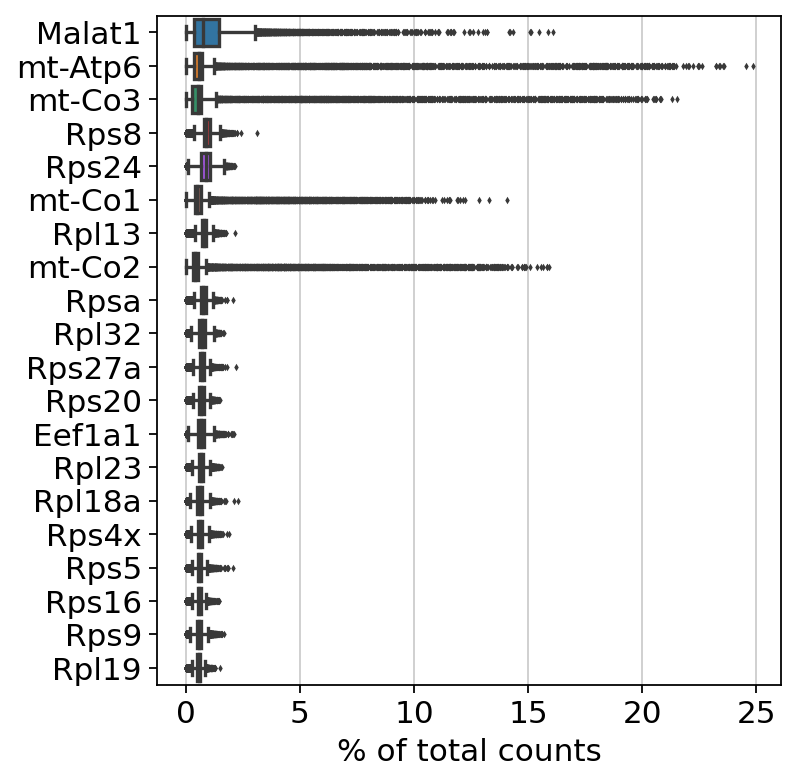

In [28]:
# Cells with a high mito genes fraction are remaining
sc.pl.highest_expr_genes(adata, n_top=20)

filtered out 3299 cells that have less than 1500 genes expressed
filtered out 8782 genes that are detected in less than 1 cells


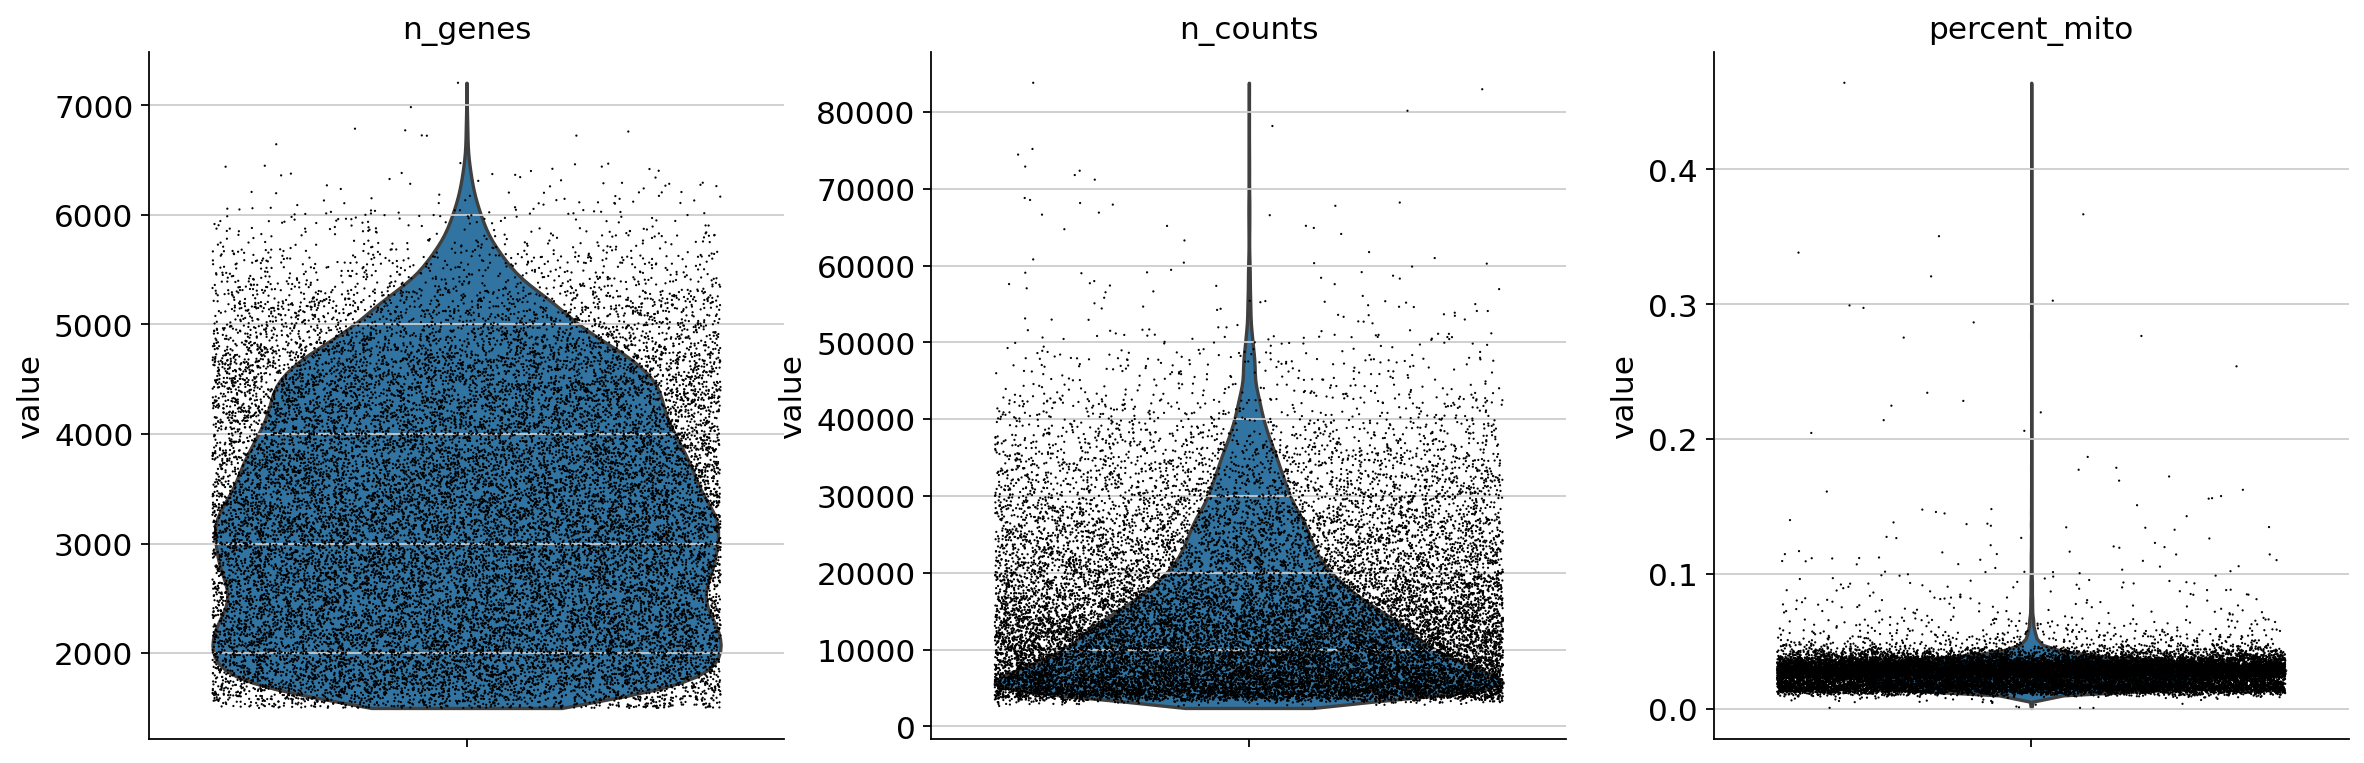

In [29]:
sc.pp.filter_cells(adata, min_genes=1500)
sc.pp.filter_genes(adata, min_cells=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

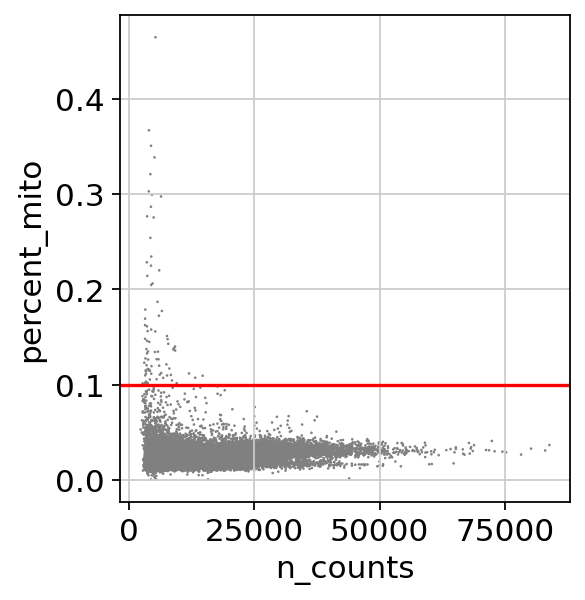

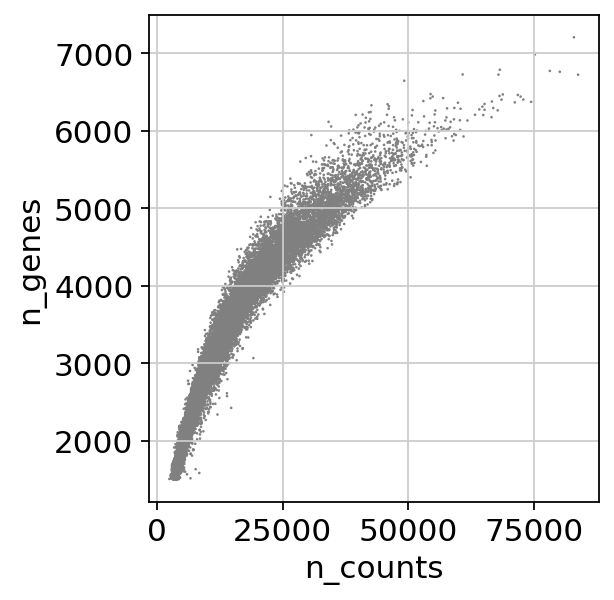

In [30]:
# mito percentage shows some dying cells, remove them
ax = sc.pl.scatter(adata, x='n_counts', y='percent_mito', show=False)
ax.axhline(y=0.1, c='red')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [31]:
# further QC with high mit percentage
adata = adata[adata.obs['percent_mito'] < 0.1, :]
print(adata.shape)

(21708, 19216)


In [32]:
print(adata.shape)
print(adata.obs['Age'].value_counts().sort_index())

(21708, 19216)
16-week    6364
68-week    7287
88-week    8057
Name: Age, dtype: int64


In [33]:
adata.write('./write/Ageing_raw_afterQC.h5ad')

# Normalisation

In [34]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# log counts
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [35]:
adata.write('./write/Ageing_norm.h5ad')

# Cell cycling

In [8]:
adata = sc.read('./write/Ageing_norm.h5ad')

In [9]:
# Scaling must be done before scoring
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [10]:
cell_cycle_genes = [x.strip().title() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [11]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [12]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


In [13]:
# save cell cycle assignments
adata.obs[['phase', 'S_score', 'G2M_score']].to_csv('cell_cycle_results.txt')

# Visualisation

In [14]:
adata = sc.read('./write/Ageing_norm.h5ad')

In [15]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [16]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes


/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


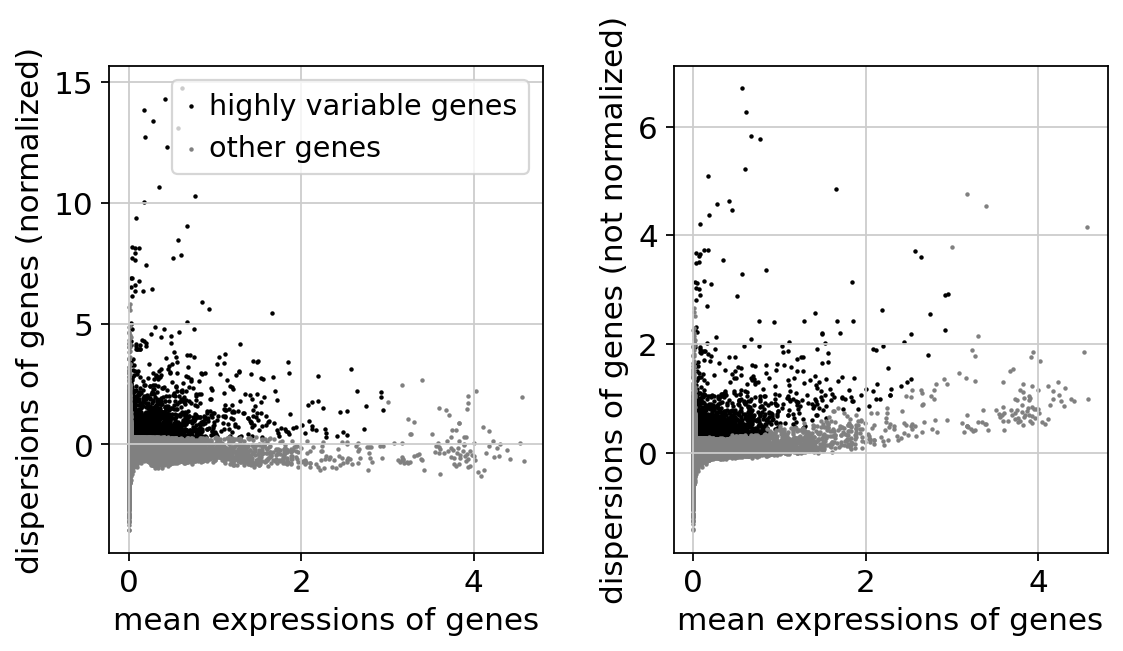

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata = adata[:, adata.var.highly_variable].copy()

In [19]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:25)
regressing out ['S_score', 'G2M_score']
    finished (0:00:22)


In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [21]:
# read in results from Project_onto_Dahlin_Landscape.ipynb notebook
DahlinL = pd.read_csv('Proj_results_dahlin.csv', index_col=0)
adata.obs['Dahlin_CT'] = DahlinL['Dahlin_CT']

In [22]:
# read in results from Project_onto_Nestorowa_Landscape.ipynb notebook
NestorowaL = pd.read_csv('Proj_results_nestorowa.csv', index_col=0)
adata.obs['Nestorowa_CT'] = NestorowaL['Nestorowa_CT']

In [23]:
# Replace the HSC and Immature populations in Dahlin Landscape with Nestorowa annotation
anno = np.array(adata.obs['Dahlin_CT'].values).copy()
idx = np.logical_or(adata.obs['Dahlin_CT'] == 'HSC', adata.obs['Dahlin_CT'] == 'Immature')
anno[idx] = adata.obs['Nestorowa_CT'][idx]
#toEx = ['MPP1', 'MPP2', 'MPP3']
#anno[[x in toEx for x in anno]] = 'MPP'
adata.obs['Combined_CT'] = anno
adata.obs['Combined_CT'] = adata.obs['Combined_CT'].astype('category')

In [24]:
adata.obs['Combined_CT'].cat.categories

Index(['Basophil', 'Early erythoid', 'GMP', 'LMPP', 'LTHSC', 'Late erythoid',
       'Lymphoid', 'MEP', 'MPP1', 'MPP2', 'MPP3', 'Megakaryocyte',
       'Middle erythoid', 'Neutrophil', 'STHSC'],
      dtype='object')

In [25]:
adata.obs['Combined_CT']= adata.obs['Combined_CT'].cat.reorder_categories([
    'LTHSC', 'STHSC', 'MPP1','MPP2','MPP3', 'LMPP',
       'GMP', 'MEP', 'Megakaryocyte', 'Early erythoid', 'Middle erythoid', 'Late erythoid','Basophil', 'Lymphoid', 'Neutrophil'])

In [26]:
MW_colors = {'LTHSC':'#B03A2E',
            'STHSC':'#EC7063',
            'MPP1':'#F39C12',
            'MPP2':'#F4D03F',
            'MPP3':'#B4EB35',
             'MPP':'#F4D03F',
            'LMPP':'#40D539',
            'GMP':'#2AADE1',
            'MEP':'#9459DF',
            'Megakaryocyte':'#CC99FF',
            'Early erythoid':'#FEB7E2',
            'Middle erythoid':'#F98796',
            'Late erythoid':'#DF582C',
            'Basophil':'#A5E5E5',
            'Lymphoid':'#8AE593',
            'Neutrophil':'#8AC0E5',
            'Unknown':'#d3d3d3'
            }

In [27]:
adata.uns['Combined_CT_colors'] = [MW_colors[x] for x in adata.obs['Combined_CT'].cat.categories]

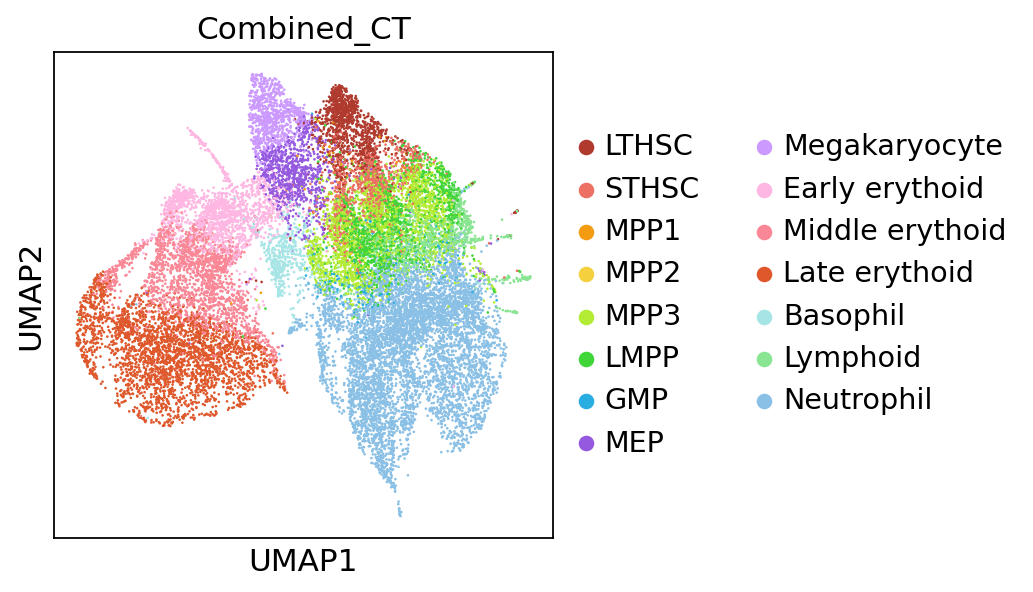

In [29]:
sc.pl.umap(adata, color='Combined_CT')

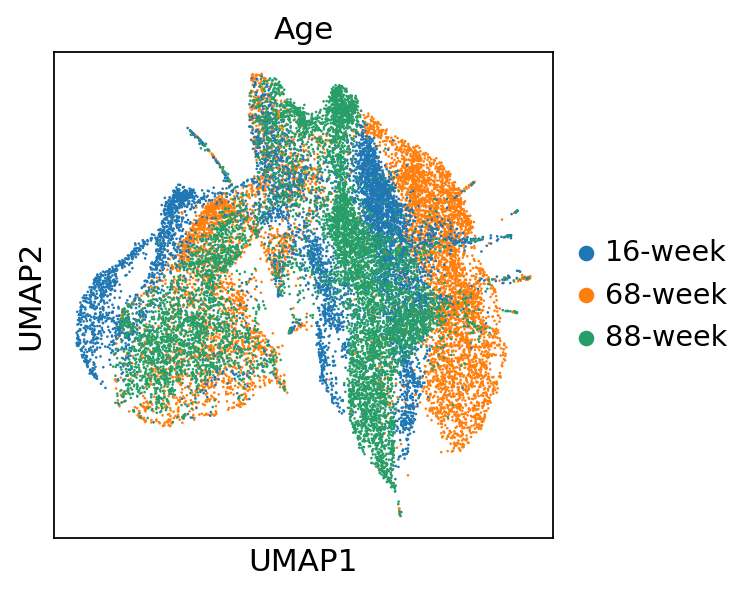

In [30]:
sc.pl.umap(adata, color='Age')

In [31]:
sc.tl.leiden(adata, resolution=0.5, key_added='Leiden_v1')

running Leiden clustering
    finished: found 18 clusters and added
    'Leiden_v1', the cluster labels (adata.obs, categorical) (0:00:02)


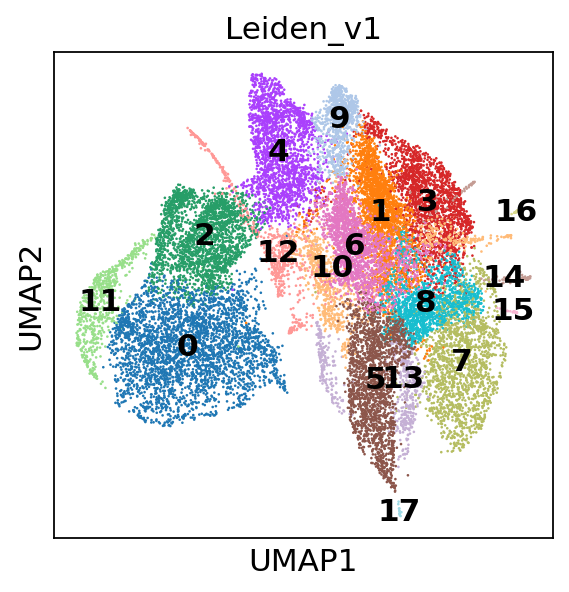

In [32]:
sc.pl.umap(adata, color='Leiden_v1', legend_loc='on data')

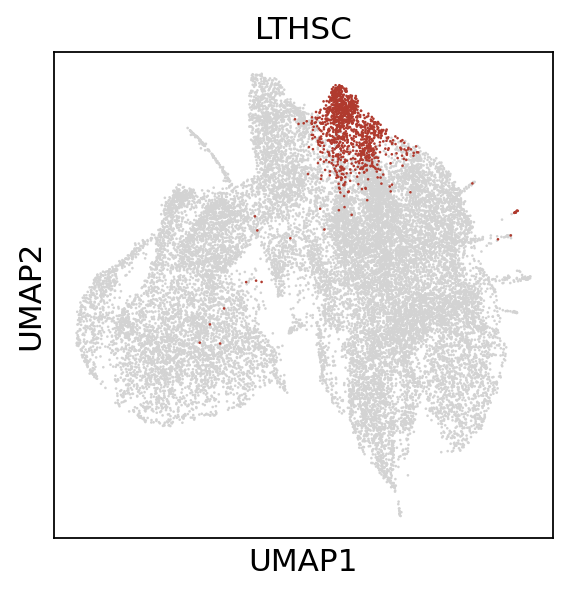

In [35]:
sc.pl.umap(adata, color='Combined_CT', groups=['LTHSC'], legend_loc='', title='LTHSC')

In [33]:
adata.write('./write/Ageing_processed.h5ad')